# Detecting hot posts by classification

1. 目的：我們收到社群輿論資料共一萬多筆貼文（posts），想要從裡面建立一個分類模型來偵測什麼樣的貼文會「爆」（假設某則post有超過100則回文（comments），以PTT的語彙來說，就是爆了）。
2. 依變項（Dependent）：依變項為每則posts的回文數，把100則回文以上的文章視為1，把少於100則回文的視為0（切勿不可將回文數當成自變項，如果這麼做就會被扣很多分數）。但你也可以嘗試以不一樣的方式去切割，但要注意盡可能保持1/0兩個分類貼文數的平衡。
3. 自變項（Independent）：至少要以貼文內容作為自變項，但可以用貼文標題、貼文作者、貼文時間來訓練。除此之外，我們還提供了前10則回文，說不定影響一則貼文會不會爆的主要因素是前十則回文。你可以自己決定要不要把回文丟下去當自變項。本作業的要求只有要求要用貼文當自變項。
4. 參考版本：助教用simpletransformer寫了個[版本](https://colab.research.google.com/drive/1YQZNlzH_mo7_Q3XU8X2sIpkhrQZWVYar?usp=sharing)給各位參考，但作為示範助教僅使用了貼文內容作為特徵來訓練模型、也使用了較少的資料集（在時間上做了點切割）。你可以使用全部的貼文來預測，或者可以嘗試加入每則貼文的前10則回文來預測。


# 讀取資料
1. 貼文資料https://github.com/p4css/PSS/blob/master/data/ptt_post.pickle
2. 回文資料https://github.com/p4css/PSS/blob/master/data/ptt_comment10.pickle 
貼文與相對應的回文資料均以plink作為key，可以用pandas的merge將兩個資料集給連結起來做訓練。但要怎麼把前十則的回文化為貼文特徵，要想想。

In [1]:
# import post data
import pickle
!wget https://github.com/P4CSS/PSS/blob/master/data/ptt_post.pickle?raw=true -O ptt_post.pickle
with open('ptt_post.pickle', 'rb') as pickle_file:
    post = pickle.load(pickle_file)

--2022-01-02 07:05:36--  https://github.com/P4CSS/PSS/blob/master/data/ptt_post.pickle?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/P4CSS/PSS/raw/master/data/ptt_post.pickle [following]
--2022-01-02 07:05:36--  https://github.com/P4CSS/PSS/raw/master/data/ptt_post.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/P4CSS/PSS/master/data/ptt_post.pickle [following]
--2022-01-02 07:05:36--  https://raw.githubusercontent.com/P4CSS/PSS/master/data/ptt_post.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [2]:
post

,plink,board,pcontent,poster,ptitle,ptime,ipaddr,ip.len,Ncomment
0,https://www.ptt.cc/bbs/Gossiping/M.1119222660....,Gossiping,"\n\n 看到這推文,忍不住要寫一個飛機沒油的例子\n 很久之前在讀者文摘上看到,現憑印象寫...",Muroi (I Honestly Love You),Re: (問題)華航空難留言,Mon Jun 20 07:28:27 2005,138.130.212.179,1,944
1,https://www.ptt.cc/bbs/Gossiping/M.1119233779....,Gossiping,\n那不是為了反盜版\n那是為了捐錢給消基會\n當年美國唱了 WE ARE THE WORL...,JCC (JCC ),Re: 有沒有明天會更好的八卦,Mon Jun 20 10:21:53 2005,211.20.78.69,1,350
2,https://www.ptt.cc/bbs/Gossiping/M.1119257927....,Gossiping,\n\n我聽到的是：\n記者問張跟路有沒有要結婚\n 家人有沒有在催。。。巴拉巴拉的\n...,vancie (我不正 我很歪 ),Re: [新聞] 張震月的八卦有嗎？,Mon Jun 20 17:07:13 2005,※ 發信站: 批踢踢實業坊(ptt.cc),0,156
3,https://www.ptt.cc/bbs/Gossiping/M.1119258686....,Gossiping,"\n太想被M,得到P幣\n再八卦一下\n\n桌伯元先生真的不是台大法學碩士\n\n它是\n國...",J1 (andy),Re: [政商] 請問桌伯元的八卦?,Mon Jun 20 17:18:14 2005,220.141.159.23,1,160
4,https://www.ptt.cc/bbs/Gossiping/M.1119271499....,Gossiping,\n\n米其林是家輪胎公司\n米其林兄弟發行了一本只送不賣的輪胎手冊\n讓所有自動車 自行車...,ilcd (南特 巴黎 白朗峰!!! ),Re: 有沒有米其淋的美食還是什麼評鑑八卦,Mon Jun 20 20:53:24 2005,218.167.152.79,1,153
...,...,...,...,...,...,...,...,...,...
12144,https://www.ptt.cc/bbs/Gossiping/M.1594181669....,Gossiping,\n1.媒體來源:\nSETN三立新聞網\n\n2.記者署名:\n大陸中心／魏聖凌報導\n\...,SilverFlare (銀白閃焰),[新聞] 暴雨襲恐潰壩？湖北水庫爆變形垮塌當局嚇,Wed Jul 8 12:14:26 2020,36.238.77.37,1,60
12145,https://www.ptt.cc/bbs/Gossiping/M.1594183031....,Gossiping,\n1.媒體來源:\napple\n\n2.記者署名:\n黃任膺／台中報導\n\n3.完整新...,bigDwinsch (胸奴王),[新聞] 中市府副秘書長朱康震被爆劈4女 好巧！請假一周去健康檢查,Wed Jul 8 12:37:08 2020,110.26.72.88,1,57
12146,https://www.ptt.cc/bbs/Gossiping/M.1594183071....,Gossiping,\n\n現場已封鎖\n\n中國國家文物局截至7月7日下午16時，南方11省份有130餘處不可...,STAV72 (刁民黨黨務主委),[爆卦] 武當山五龍宮龍虎殿垮了！,Wed Jul 8 12:37:49 2020,49.216.167.110,1,189
12147,https://www.ptt.cc/bbs/Gossiping/M.1594190904....,Gossiping,"\n1.媒體來源:\n中時電子報,旺報\n\n2.記者署名:\n李侑珊\n\n3.完整新聞標...",Tcdamh (劣),[新聞] 陸配無法回台生子遭踢皮球 夫嘆：人道與,Wed Jul 8 14:48:22 2020,118.163.180.245,1,115


# 切割資料集

In [3]:
import numpy as np
import pandas as pd
import re

# 新增label欄，超過100則留言的為1
post['labels'] = pd.cut(post.Ncomment, bins=[-np.inf, 100, np.inf], labels=[0, 1])
# 清理貼文內容
post.pcontent	= post.pcontent.apply(lambda x: re.sub(r'\n+', '\n', x).strip())
post.pcontent = post.pcontent.apply(lambda x: x.replace('\n', ' ').strip()[:500])

post

,plink,board,pcontent,poster,ptitle,ptime,ipaddr,ip.len,Ncomment,labels
0,https://www.ptt.cc/bbs/Gossiping/M.1119222660....,Gossiping,"看到這推文,忍不住要寫一個飛機沒油的例子 很久之前在讀者文摘上看到,現憑印象寫文,有錯請指...",Muroi (I Honestly Love You),Re: (問題)華航空難留言,Mon Jun 20 07:28:27 2005,138.130.212.179,1,944,1
1,https://www.ptt.cc/bbs/Gossiping/M.1119233779....,Gossiping,那不是為了反盜版 那是為了捐錢給消基會 當年美國唱了 WE ARE THE WORLD之後 ...,JCC (JCC ),Re: 有沒有明天會更好的八卦,Mon Jun 20 10:21:53 2005,211.20.78.69,1,350,1
2,https://www.ptt.cc/bbs/Gossiping/M.1119257927....,Gossiping,我聽到的是： 記者問張跟路有沒有要結婚 家人有沒有在催。。。巴拉巴拉的 張覺得很煩，就...,vancie (我不正 我很歪 ),Re: [新聞] 張震月的八卦有嗎？,Mon Jun 20 17:07:13 2005,※ 發信站: 批踢踢實業坊(ptt.cc),0,156,1
3,https://www.ptt.cc/bbs/Gossiping/M.1119258686....,Gossiping,"太想被M,得到P幣 再八卦一下 桌伯元先生真的不是台大法學碩士 它是 國立台灣大學法律系學士...",J1 (andy),Re: [政商] 請問桌伯元的八卦?,Mon Jun 20 17:18:14 2005,220.141.159.23,1,160,1
4,https://www.ptt.cc/bbs/Gossiping/M.1119271499....,Gossiping,米其林是家輪胎公司 米其林兄弟發行了一本只送不賣的輪胎手冊 讓所有自動車 自行車 機車的車主...,ilcd (南特 巴黎 白朗峰!!! ),Re: 有沒有米其淋的美食還是什麼評鑑八卦,Mon Jun 20 20:53:24 2005,218.167.152.79,1,153,1
...,...,...,...,...,...,...,...,...,...,...
12144,https://www.ptt.cc/bbs/Gossiping/M.1594181669....,Gossiping,1.媒體來源: SETN三立新聞網 2.記者署名: 大陸中心／魏聖凌報導 3.完整新聞標題:...,SilverFlare (銀白閃焰),[新聞] 暴雨襲恐潰壩？湖北水庫爆變形垮塌當局嚇,Wed Jul 8 12:14:26 2020,36.238.77.37,1,60,0
12145,https://www.ptt.cc/bbs/Gossiping/M.1594183031....,Gossiping,1.媒體來源: apple 2.記者署名: 黃任膺／台中報導 3.完整新聞標題: 中市府副秘...,bigDwinsch (胸奴王),[新聞] 中市府副秘書長朱康震被爆劈4女 好巧！請假一周去健康檢查,Wed Jul 8 12:37:08 2020,110.26.72.88,1,57,0
12146,https://www.ptt.cc/bbs/Gossiping/M.1594183071....,Gossiping,現場已封鎖 中國國家文物局截至7月7日下午16時，南方11省份有130餘處不可移動文物因洪災...,STAV72 (刁民黨黨務主委),[爆卦] 武當山五龍宮龍虎殿垮了！,Wed Jul 8 12:37:49 2020,49.216.167.110,1,189,1
12147,https://www.ptt.cc/bbs/Gossiping/M.1594190904....,Gossiping,"1.媒體來源: 中時電子報,旺報 2.記者署名: 李侑珊 3.完整新聞標題: 陸配無法回台生...",Tcdamh (劣),[新聞] 陸配無法回台生子遭踢皮球 夫嘆：人道與,Wed Jul 8 14:48:22 2020,118.163.180.245,1,115,1


In [4]:
!pip install -q -U simpletransformers
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel

     |████████████████████████████████| 247 kB 12.2 MB/s 
     |████████████████████████████████| 306 kB 49.1 MB/s 
     |████████████████████████████████| 1.7 MB 47.8 MB/s 
     |████████████████████████████████| 1.2 MB 51.7 MB/s 
     |████████████████████████████████| 6.8 MB 50.7 MB/s 
     |████████████████████████████████| 3.4 MB 40.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 9.2 MB 45.7 MB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
     |████████████████████████████████| 61 kB 532 kB/s 
     |████████████████████████████████| 895 kB 27.8 MB/s 
     |████████████████████████████████| 3.3 MB 40.1 MB/s 
     |████████████████████████████████| 97 kB 5.5 MB/s 
     |████████████████████████████████| 140 kB 50.4 MB/s 
     |████████████████████████████████| 180 kB 53.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 132 kB 53.0 MB/s 
     |████████████████

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
    
!nvidia-smi

Sun Jan  2 07:07:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import logging

model_args = { 
    'manual_seed': 0,
    'use_early_stopping': True,
    'max_seq_length': 256,
    'train_batch_size': 16,
    'num_train_epochs': 10,
    'overwrite_output_dir': True,
    'load_best_model_at_end': True,
} 
 
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

model = ClassificationModel('bert', 'bert-base-chinese', num_labels=2, args=model_args)

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [7]:
test_df = post.iloc[int(post.shape[0]*.9):]
post = post.drop(test_df.index)
train_df, eval_df = train_test_split(post, test_size=0.2, stratify=post.labels) 

# 訓練模型

In [8]:
# training
model.train_model(train_df[['pcontent', 'labels']]) 

# validation
result, model_outputs, wrong_predictions = model.eval_model(eval_df[['pcontent','labels']]) 

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/8747 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_256_2_2


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/547 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2187 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_256_2_2


Running Evaluation:   0%|          | 0/274 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.27293410160447446, 'tp': 708, 'tn': 684, 'fp': 391, 'fn': 404, 'auroc': 0.6673055044336624, 'auprc': 0.6499085357148879, 'eval_loss': 2.532578181937663}


# 預測結果
預測結果應包含`classification_report`並應用`from mlxtend.plotting import plot_confusion_matrix`繪製confision_matrix的視覺化結果。

In [9]:
result

{'auprc': 0.6499085357148879,
 'auroc': 0.6673055044336624,
 'eval_loss': 2.532578181937663,
 'fn': 404,
 'fp': 391,
 'mcc': 0.27293410160447446,
 'tn': 684,
 'tp': 708}

In [10]:
predictions, raw_outputs = model.predict(test_df['pcontent'].to_list())

test_df['predict'] = predictions
test_df['correct'] = pd.cut(test_df.Ncomment, bins=[-np.inf, 100, np.inf], labels=[0, 1])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1215 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

           0       0.56      0.57      0.56       501
           1       0.69      0.68      0.69       714

    accuracy                           0.64      1215
   macro avg       0.63      0.63      0.63      1215
weighted avg       0.64      0.64      0.64      1215



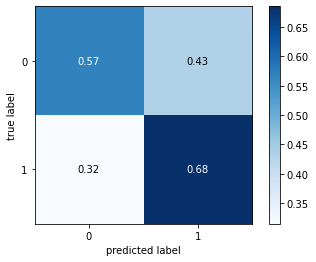

In [11]:
# Visualization
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

print(classification_report(test_df['correct'].to_list(), test_df['predict'].to_list()))
cm = confusion_matrix(test_df['correct'].to_list(), test_df['predict'].to_list())


figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

# 分析預測結果
Q1. 你把什麼樣的特徵丟進去當自變項（最基本要有貼文，但你還可以丟貼文的發文者、時間、標題、前十則回文內容、回文作者）？
> 貼文內容

Q2. 你認為這個模型的分類能力好嗎？請說明模型訓練結果。
> 視覺化結果顯示準確度約為64%，若以label=1來說，精確度可接近七成，而正確預測為爆文（True1）的比率是0.68，正確預測為非爆文（True0）為0.57，可見正確率至少都大於50%，分類能力整體來說還不錯。

Q3. 你認為ptt貼文內容適合拿來做訓練資料嗎？為什麼？
> 本次ptt資料集達12000筆以上，80%作為訓練資料共有九千多筆，數量夠多。另外，label的分類為二分法，只要從回文數是否超過100來判斷，所以資料前置處理很方便。但是每筆貼文的獨立性要視是否討論同一主題而定，如果連續好幾篇貼文都是回覆某篇的討論，那資料間就有相關性，會降低模型的準確率，若每篇貼文大多是不同主題，那就非常適合用來訓練模型。本次作業是以貼文內容當作依變項，但我們無法知道貼文裡的什麼詞語或內容成為影響結果的因素，所以跑完模型也很難得到具體的結論說什麼貼文內容會影響是否爆文，只能大概做為分類的一種篩選。

Q4. 若加入其他參考特徵後，模型有什麼樣的改變呢（如果你沒做的話就不用回答）？
> 無

Q5. 如果你在Daily Scrum上要回報這個任務，請用100字以上、200字以內精簡且精準地回報模型訓練結果。
> 本模型用simpletransformer二分法預測ptt貼文是否會爆，自變項是爆或不爆，依變項只有貼文內容的文字，訓練模型的準確率大約落在60%到70%之間，而且模型正確判斷為爆文的正確率會比正確判斷成不爆還要高一成左右。